<a href="https://colab.research.google.com/github/Asciotti/neural-sar/blob/master/notebooks/1_simple_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reimplementing simple encoder-decoder network to colorize images

Ref [Generating High Quality Visible Images from SAR Images Using CNNs](https://arxiv.org/abs/1802.10036) by Puyang Wang & Vishal M. Patel

## Data Sources

~3k [High Resolution Orthoimages](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-aerial-photography-high-resolution-orthoimagery-hro?qt-science_center_objects=0#qt-science_center_objects) manually downloaded from https://earthexplorer.usgs.gov/ 

Images should have 1m/pixel resolution.

## Network Architecture

Below is the encoder-decoder network leveraging skip connections that is being utilized. Note, in my implementation the input and output data set is slightly different. There is no "despeckle" component to the network. Also note, due to VRAM constraints on Google Collab, the number of filters in each Conv layer is halved.

![](https://github.com/Asciotti/neural-sar/blob/master/notebooks/resources/autoencoder.PNG?raw=1)

### Load data from google drive

In [6]:
# I currently store my data on google drive, but it is stored in the repo under 
# https://github.com/Asciotti/neural-sar/tree/master/notebooks/data
# You can also manually upload the data each session
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Imports

In [0]:
import time
import numpy as np
# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 4
plt.style.use(['seaborn-darkgrid'])
# Image 
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import histogram
# Keras
import keras
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,Add
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.callbacks import *

### Load Example image

In [8]:
im = imread('/content/drive/My Drive/Colab Notebooks/1_ft_ortho_images/1.png')
print('Input RGB image shape: ', im.shape)
print('Input Gray image shape: ', rgb2gray(im).shape)

Input RGB image shape:  (512, 512, 3)
Input Gray image shape:  (512, 512)


Text(0.5, 1.0, 'Color High Res Image')

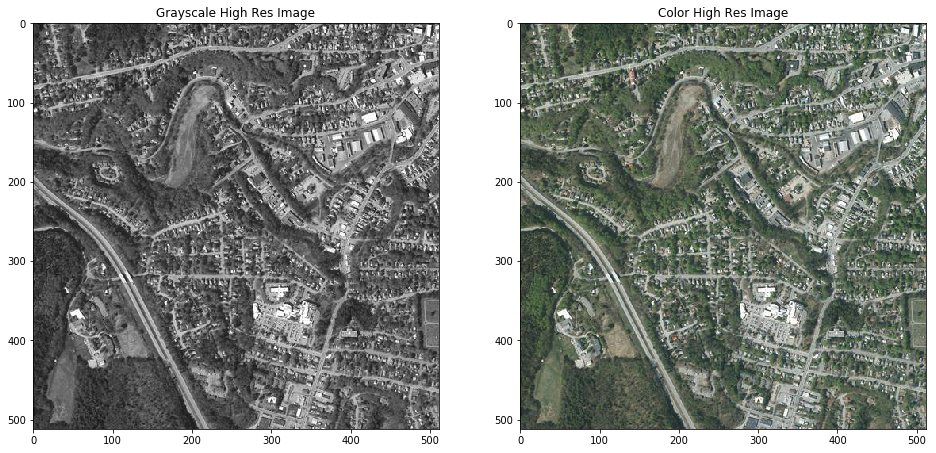

In [9]:
fig, axes = plt.subplots(1,2,figsize=(16,16))
axes[0].imshow(rgb2gray(im), cmap='gray')
axes[0].set_title('Grayscale High Res Image')
axes[1].imshow(im, cmap='gray')
axes[1].set_title('Color High Res Image')

### Helper functions to load and process data

Note: The images are resized from (512,512) to (256,256) for quicker training and due to VRAM constraints in Google Collab


In [0]:
def get_image(name):
    
    img = imread('/content/drive/My Drive/Colab Notebooks/1_ft_ortho_images/'  + str(int(name)) + '.png', as_gray=False)
    # Resize to 256,256
    img = resize(img, (256,256,3))
    # Rescale to [0,1]
    if np.max(img) > 1:
      img = img/255.0
    
    return(img)

In [0]:
def image_generator(indices,batch_size = 32):
    
    while True:
          # Select files (paths/indices) for the batch
          batch_paths = np.random.choice(a = indices, 
                                         size = batch_size)
          batch_input = []
          batch_output = [] 
          # Read in each input, make in/truth images
          for input_path in batch_paths:
              # Get raw RBG image
              image = get_image(input_path)
              # Extract out RBG and Grayscale images
              input = resize(rgb2gray(image), (256,256,1))
              output = image
              batch_input += [ input ]
              batch_output += [ output ]
          # Return a tuple of (input,output) to feed the network
          batch_x = np.array( batch_input )
          batch_y = np.array( batch_output )
        
          yield( batch_x, batch_y )

(1, 256, 256, 1)
(1, 256, 256, 3)


Text(0.5, 1.0, 'Color')

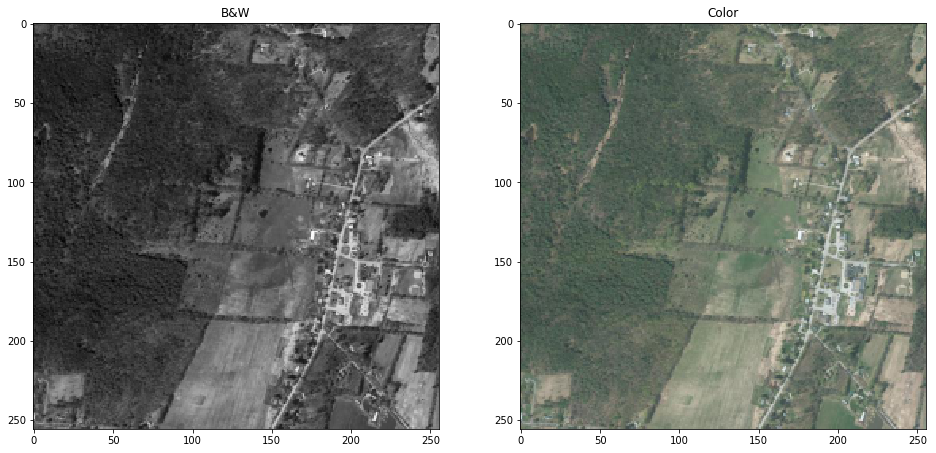

In [28]:
# Test generator & loader
im_gen = image_generator([68], 1)
X_img, y_truth = im_gen.__next__()
print(X_img.shape)
print(y_truth.shape)
fig, axes = plt.subplots(1,2,figsize=(16,16))
axes[0].imshow(X_img.reshape(256,256), cmap='gray')
axes[0].set_title('B&W')
axes[1].imshow(y_truth.reshape(256,256,3))
axes[1].set_title('Color')

### Create the NN model

In [0]:
def make_model():
    inpt = Input(shape=(256,256,1))
    # Layer 1
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    _skip1 = x
    # Layer 2
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=0.0001)(x)
    x = Activation('relu')(x)
    _skip2 = x
    # Layer 3
    x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=0.0001)(x)
    x = Activation('relu')(x)
    _skip3 = x
    # Layer 4
    x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=0.0001)(x)
    x = Activation('relu')(x)
    # Layer 5
    x = Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=0.0001)(x)
    x = Activation('relu')(x)
    x = Add()([x, _skip3])
    # Layer 6
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=0.0001)(x)
    x = Activation('relu')(x)
    x = Add()([x, _skip2])
    # Layer 7
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis=3, epsilon=0.0001)(x)
    x = Activation('relu')(x)
    x = Add()([x, _skip1])
    # Layer 8
    x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # End
    x = Activation('tanh')(x)   
    
    model = Model(inputs=inpt, outputs=x)
    
    return model


In [24]:
model = make_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 32) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 32) 9248        activation_19[0][0]              
____________________________________________________________________________________________

### Train the model

In [0]:
# Set number of images you want to train on, takes a while so starting w/ roughly 1/3 of data set
ind = range(1,1000)
# Set epochs
epochs = 20
# Set batch size
batch_size=32
# Set steps_per_epoch
steps_per_epoch = len(ind)/batch_size
  # Total number of steps (batches of samples) to yield from generator before 
  # declaring one epoch finished and starting the next epoch. 
  # It should typically be equal to the number of unique samples of your 
  # dataset divided by the batch size.

In [31]:
# Get current time so each trained model is timestamped
# Recommended to leave this as one cell so you never forget to rerun the new time
t_now = time.strftime('%Y%m%d_%H%M%S', time.localtime())
# Make Keras ModelCheckpoint to save off trained model at intervals
filepath="/content/drive/My Drive/MyCNN/" + t_now + "_weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=False,save_best_only=True)


model.compile(optimizer=Adam(0.001), loss='mse')
history = model.fit_generator(image_generator(ind, batch_size), steps_per_epoch=10, epochs=epochs, verbose=1,\
                             callbacks=[checkpoint])
json.dump(history.history, open("/content/drive/My Drive/MyCNN/" + t_now + "_history.json", 'w'))

Epoch 1/20
10/10 [==============================] - 126s 13s/step - loss: 0.0131
Epoch 2/20
10/10 [==============================] - 87s 9s/step - loss: 0.0042
Epoch 3/20
10/10 [==============================] - 66s 7s/step - loss: 0.0026
Epoch 4/20
10/10 [==============================] - 56s 6s/step - loss: 0.0018
Epoch 5/20
10/10 [==============================] - 47s 5s/step - loss: 0.0018
Epoch 6/20
10/10 [==============================] - 33s 3s/step - loss: 0.0015
Epoch 7/20
10/10 [==============================] - 30s 3s/step - loss: 0.0016
Epoch 8/20
10/10 [==============================] - 20s 2s/step - loss: 9.3647e-04
Epoch 9/20
10/10 [==============================] - 21s 2s/step - loss: 0.0014
Epoch 10/20
10/10 [==============================] - 22s 2s/step - loss: 0.0012
Epoch 11/20
10/10 [==============================] - 18s 2s/step - loss: 9.6727e-04
Epoch 12/20
10/10 [==============================] - 15s 2s/step - loss: 8.3772e-04
Epoch 13/20
10/10 [================

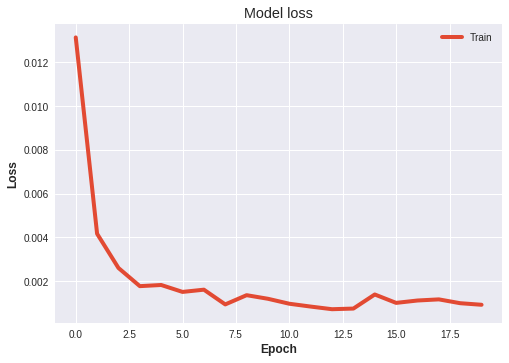

In [80]:
# Plot model loss over time
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Using trained model, predict output on un-used image

In [48]:
# Get last image since we didn't use for testing, and feed forward through model
X_test, y_test = image_generator([3000], 1).__next__()
y_predict = model.predict(X_test)

X_test = X_test.reshape((256,256))
y_predict = y_predict.reshape((256,256,3))
y_test = y_test.reshape((256,256,3))


(256, 256) (256, 256, 3) (256, 256, 3)


Text(0.5, 1.0, 'Truth')

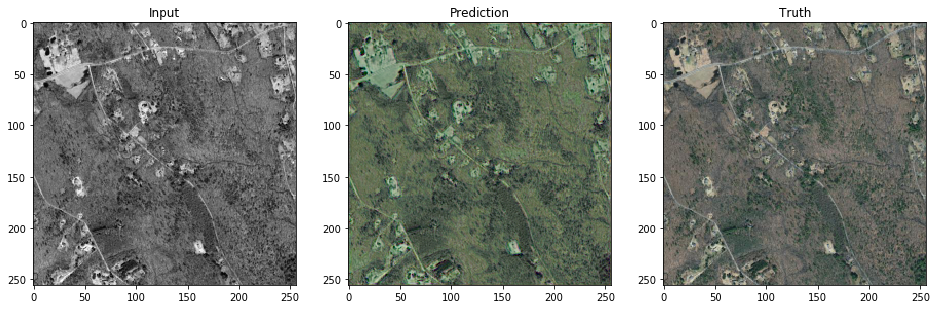

In [50]:
# Make figures
fig, axes = plt.subplots(1,3,figsize=(16,16))
axes[0].imshow(X_test, cmap='gray')
axes[0].set_title('Input')
axes[1].imshow(y_predict)
axes[1].set_title('Prediction')
axes[2].imshow(y_test)
axes[2].set_title('Truth')

### Analyze difference between predicted image and ground truth image

The predicted image appears to have this green hue to it. Looking at the final images in the reference paper, it appears they have a similar issue. By using MSE/L2 loss, training lends itself to producing colored images that are conservative, i.e. more washed out and closer to the average of all images rather than promoting a diverse color palette. Ref'ing [Colorful Image Colorization by Zhang et. al](https://arxiv.org/abs/1603.08511), this is common issue with a non-tailored loss functions in image colorization. From Zhang, "the optimal solution to the Euclidean loss will be the mean of the
set. In color prediction, this averaging effect favors grayish, desaturated results."

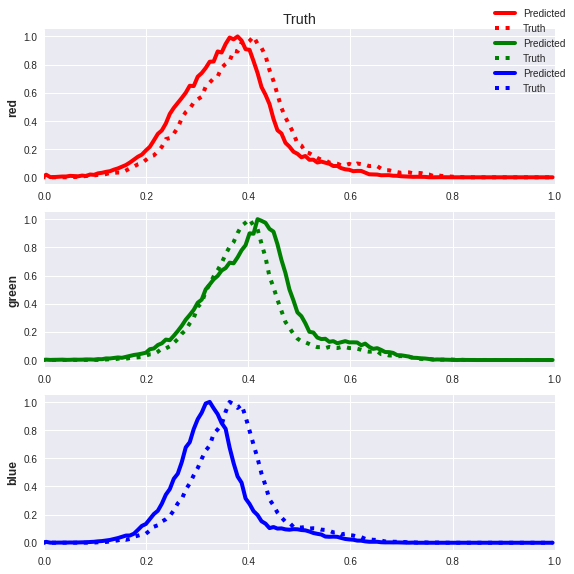

In [107]:
fig, axes = plt.subplots(3,1,figsize=(8,8))
 
for i, img in enumerate((y_predict, y_test)):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = histogram(img[..., c], source_range='dtype')
        line_type = ':' if i == 1 else '-'
        label = 'Predicted' if i == 0 else 'Truth'
        axes[c].plot(bins, img_hist / img_hist.max(), linestyle=line_type, color=c_color, label=label)
        axes[c].set_ylabel(c_color)
        axes[c].set_xlim([0, 1])

axes[0].set_title('Predicted')
axes[0].set_title('Truth')
fig.legend()
fig.tight_layout()